# Chapter 2: Linear Regression with Real Estate Data

## Learning Objectives

In this chapter, you will learn:
- **Mathematical foundations** of linear regression with proper derivations
- **Data collection** from real estate websites for regression analysis  
- **Implementation** from scratch using NumPy
- **Scikit-learn** implementation for comparison
- **Model evaluation** and interpretation techniques
- **Assumptions** and diagnostics for linear regression

## Introduction

Linear regression is the foundation of predictive modeling and one of the most important algorithms in machine learning. It models the relationship between a dependent variable and independent variables by fitting a linear equation to observed data.

**Mathematical Foundation**: Linear regression finds the best-fitting line through data points by minimizing the sum of squared residuals, as originally formulated by Legendre (1805) and Gauss (1809) (Stigler, 1981).

## Mathematical Theory

### The Linear Model

For a single predictor variable, the linear regression model is:

$$y = \beta_0 + \beta_1 x + \epsilon$$

Where:
- $y$ is the dependent variable (response)
- $x$ is the independent variable (predictor)  
- $\beta_0$ is the y-intercept
- $\beta_1$ is the slope coefficient
- $\epsilon$ is the error term

For multiple predictors:

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_p x_p + \epsilon$$

Or in matrix form: $\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}$

**Citation**: The mathematical foundations are detailed in Hastie et al. (2009) and James et al. (2013).

### Least Squares Estimation

The ordinary least squares (OLS) estimator minimizes the residual sum of squares:

$$RSS = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \sum_{i=1}^{n} (y_i - \beta_0 - \beta_1 x_i)^2$$

The closed-form solution is:

$$\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

**Citation**: The derivation and properties of OLS are covered in Greene (2003).

In [1]:
# Import required libraries
import sys
import os

# Add utils directory to path for imports
utils_path = os.path.abspath(os.path.join('..', 'utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

import numpy as np
import pandas as pd

# Configure matplotlib for proper inline display BEFORE importing pyplot
import matplotlib
# Set backend for Jupyter notebook inline display
try:
    # Try to set inline backend for notebook display
    get_ipython()  # This will raise NameError if not in IPython/Jupyter
    matplotlib.use('module://matplotlib_inline.backend_inline')
except NameError:
    # Not in Jupyter, use a backend that works for static plots
    matplotlib.use('Agg')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings

# Import utility functions
try:
    from data_utils import save_data, load_data, check_data_quality
    from plot_utils import save_and_show_plot
    print("✓ Utility functions imported successfully")
except ImportError as e:
    print(f"⚠ Could not import utilities: {e}")
    # Define basic save_data function as fallback
    def save_data(data, filepath, format='csv'):
        import json
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        if format == 'csv' and hasattr(data, 'to_csv'):
            data.to_csv(filepath, index=False)
        elif format == 'json':
            if hasattr(data, 'to_json'):
                data.to_json(filepath, orient='records', date_format='iso')
            else:
                with open(filepath, 'w') as f:
                    json.dump(data, f, indent=2, default=str)
        return filepath

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'figure.dpi': 100,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'lines.linewidth': 2,
    'grid.alpha': 0.3
})

# Enable inline plotting for Jupyter
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn available: {'sklearn' in sys.modules or 'sklearn' in [m.split('.')[0] for m in sys.modules]}")
print(f"Matplotlib backend: {matplotlib.get_backend()}")
print("Ready for linear regression analysis!")

✓ Utility functions imported successfully
Libraries imported successfully!
NumPy version: 2.2.6
Pandas version: 2.3.1
Scikit-learn available: True
Matplotlib backend: inline
Ready for linear regression analysis!


## Data Collection: Real Estate Prices

For our linear regression analysis, we'll collect real estate data that naturally exhibits linear relationships between features like square footage, number of bedrooms, and price.

**Real-World Application**: Housing price prediction is a classic application of linear regression in economics and real estate, as documented by Case & Shiller (1989).

Since we need to be ethical about web scraping, we'll simulate realistic real estate data based on actual market patterns and relationships.

In [2]:
def simulate_real_estate_data(n_samples: int = 1000, random_state: int = 42) -> pd.DataFrame:
    """
    Simulate realistic real estate data for linear regression analysis.
    
    This function creates data that mimics patterns found in real housing markets,
    with realistic relationships between features and prices.
    
    Parameters
    ----------
    n_samples : int, default=1000
        Number of properties to simulate
    random_state : int, default=42
        Random seed for reproducibility
        
    Returns
    -------
    pd.DataFrame
        Simulated real estate dataset with features and target price
    """
    np.random.seed(random_state)
    
    # Generate base features with realistic distributions
    # Square footage (log-normal distribution, typical range 800-4000 sqft)
    sqft = np.random.lognormal(mean=7.2, sigma=0.4, size=n_samples)
    sqft = np.clip(sqft, 800, 4000)
    
    # Number of bedrooms (correlated with square footage)
    # Typical relationship: 1 bedroom per ~600 sqft, with some variation
    bedrooms_base = sqft / 600 + np.random.normal(0, 0.5, n_samples)
    bedrooms = np.clip(np.round(bedrooms_base), 1, 6).astype(int)
    
    # Number of bathrooms (correlated with bedrooms, typically 0.5-1 per bedroom)
    bathrooms_base = bedrooms * 0.75 + np.random.normal(0, 0.3, n_samples)
    bathrooms = np.clip(np.round(bathrooms_base * 2) / 2, 1, 4)  # Round to nearest 0.5
    
    # Property age (0-50 years, exponential decay in frequency)
    age = np.random.exponential(scale=15, size=n_samples)
    age = np.clip(age, 0, 50)
    
    # Location score (1-10, representing neighborhood desirability)
    location_score = np.random.beta(2, 2, n_samples) * 9 + 1
    
    # Distance to city center (miles, affects price)
    distance_to_center = np.random.gamma(2, 3, n_samples)
    distance_to_center = np.clip(distance_to_center, 1, 30)
    
    # Garage (binary: 0 or 1)
    garage_prob = 0.3 + 0.4 * (sqft - 800) / (4000 - 800)  # Larger homes more likely to have garage
    garage = np.random.binomial(1, garage_prob, n_samples)
    
    # School rating (1-10, affects desirability)
    school_rating = np.random.beta(3, 2, n_samples) * 9 + 1
    
    # Generate realistic price based on these features
    # Base price equation with realistic coefficients
    price_base = (
        100 * sqft +                           # $100 per sqft
        15000 * bedrooms +                     # $15k per bedroom
        8000 * bathrooms +                     # $8k per bathroom  
        -2000 * age +                          # -$2k per year of age
        25000 * location_score +               # $25k per location point
        -3000 * distance_to_center +           # -$3k per mile from center
        20000 * garage +                       # $20k for garage
        5000 * school_rating                   # $5k per school rating point
    )
    
    # Add realistic noise (market fluctuations, unmeasured factors)
    noise = np.random.normal(0, 0.1 * price_base, n_samples)
    price = price_base + noise
    
    # Ensure prices are reasonable (minimum $50k)
    price = np.maximum(price, 50000)
    
    # Create DataFrame
    data = pd.DataFrame({
        'sqft': np.round(sqft).astype(int),
        'bedrooms': bedrooms,
        'bathrooms': bathrooms,
        'age': np.round(age, 1),
        'location_score': np.round(location_score, 1),
        'distance_to_center': np.round(distance_to_center, 1),
        'garage': garage,
        'school_rating': np.round(school_rating, 1),
        'price': np.round(price).astype(int)
    })
    
    return data

# Generate the dataset
print("Generating realistic real estate dataset...")
real_estate_data = simulate_real_estate_data(n_samples=1000, random_state=42)

print(f"Dataset created with {len(real_estate_data)} properties")
print("\nDataset Info:")
print(real_estate_data.info())
print("\nFirst 10 properties:")
print(real_estate_data.head(10))

print("\nBasic Statistics:")
print(real_estate_data.describe())

Generating realistic real estate dataset...
Dataset created with 1000 properties

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sqft                1000 non-null   int64  
 1   bedrooms            1000 non-null   int64  
 2   bathrooms           1000 non-null   float64
 3   age                 1000 non-null   float64
 4   location_score      1000 non-null   float64
 5   distance_to_center  1000 non-null   float64
 6   garage              1000 non-null   int32  
 7   school_rating       1000 non-null   float64
 8   price               1000 non-null   int64  
dtypes: float64(5), int32(1), int64(3)
memory usage: 66.5 KB
None

First 10 properties:
   sqft  bedrooms  bathrooms   age  location_score  distance_to_center  \
0  1634         3        2.0  25.6             3.9                 1.7   
1  1267         3       

## Exploratory Data Analysis

Before building our regression model, we need to understand the data distribution, relationships, and potential issues.

**Citation**: The importance of exploratory data analysis is emphasized by Tukey (1977) and Cleveland (1993).

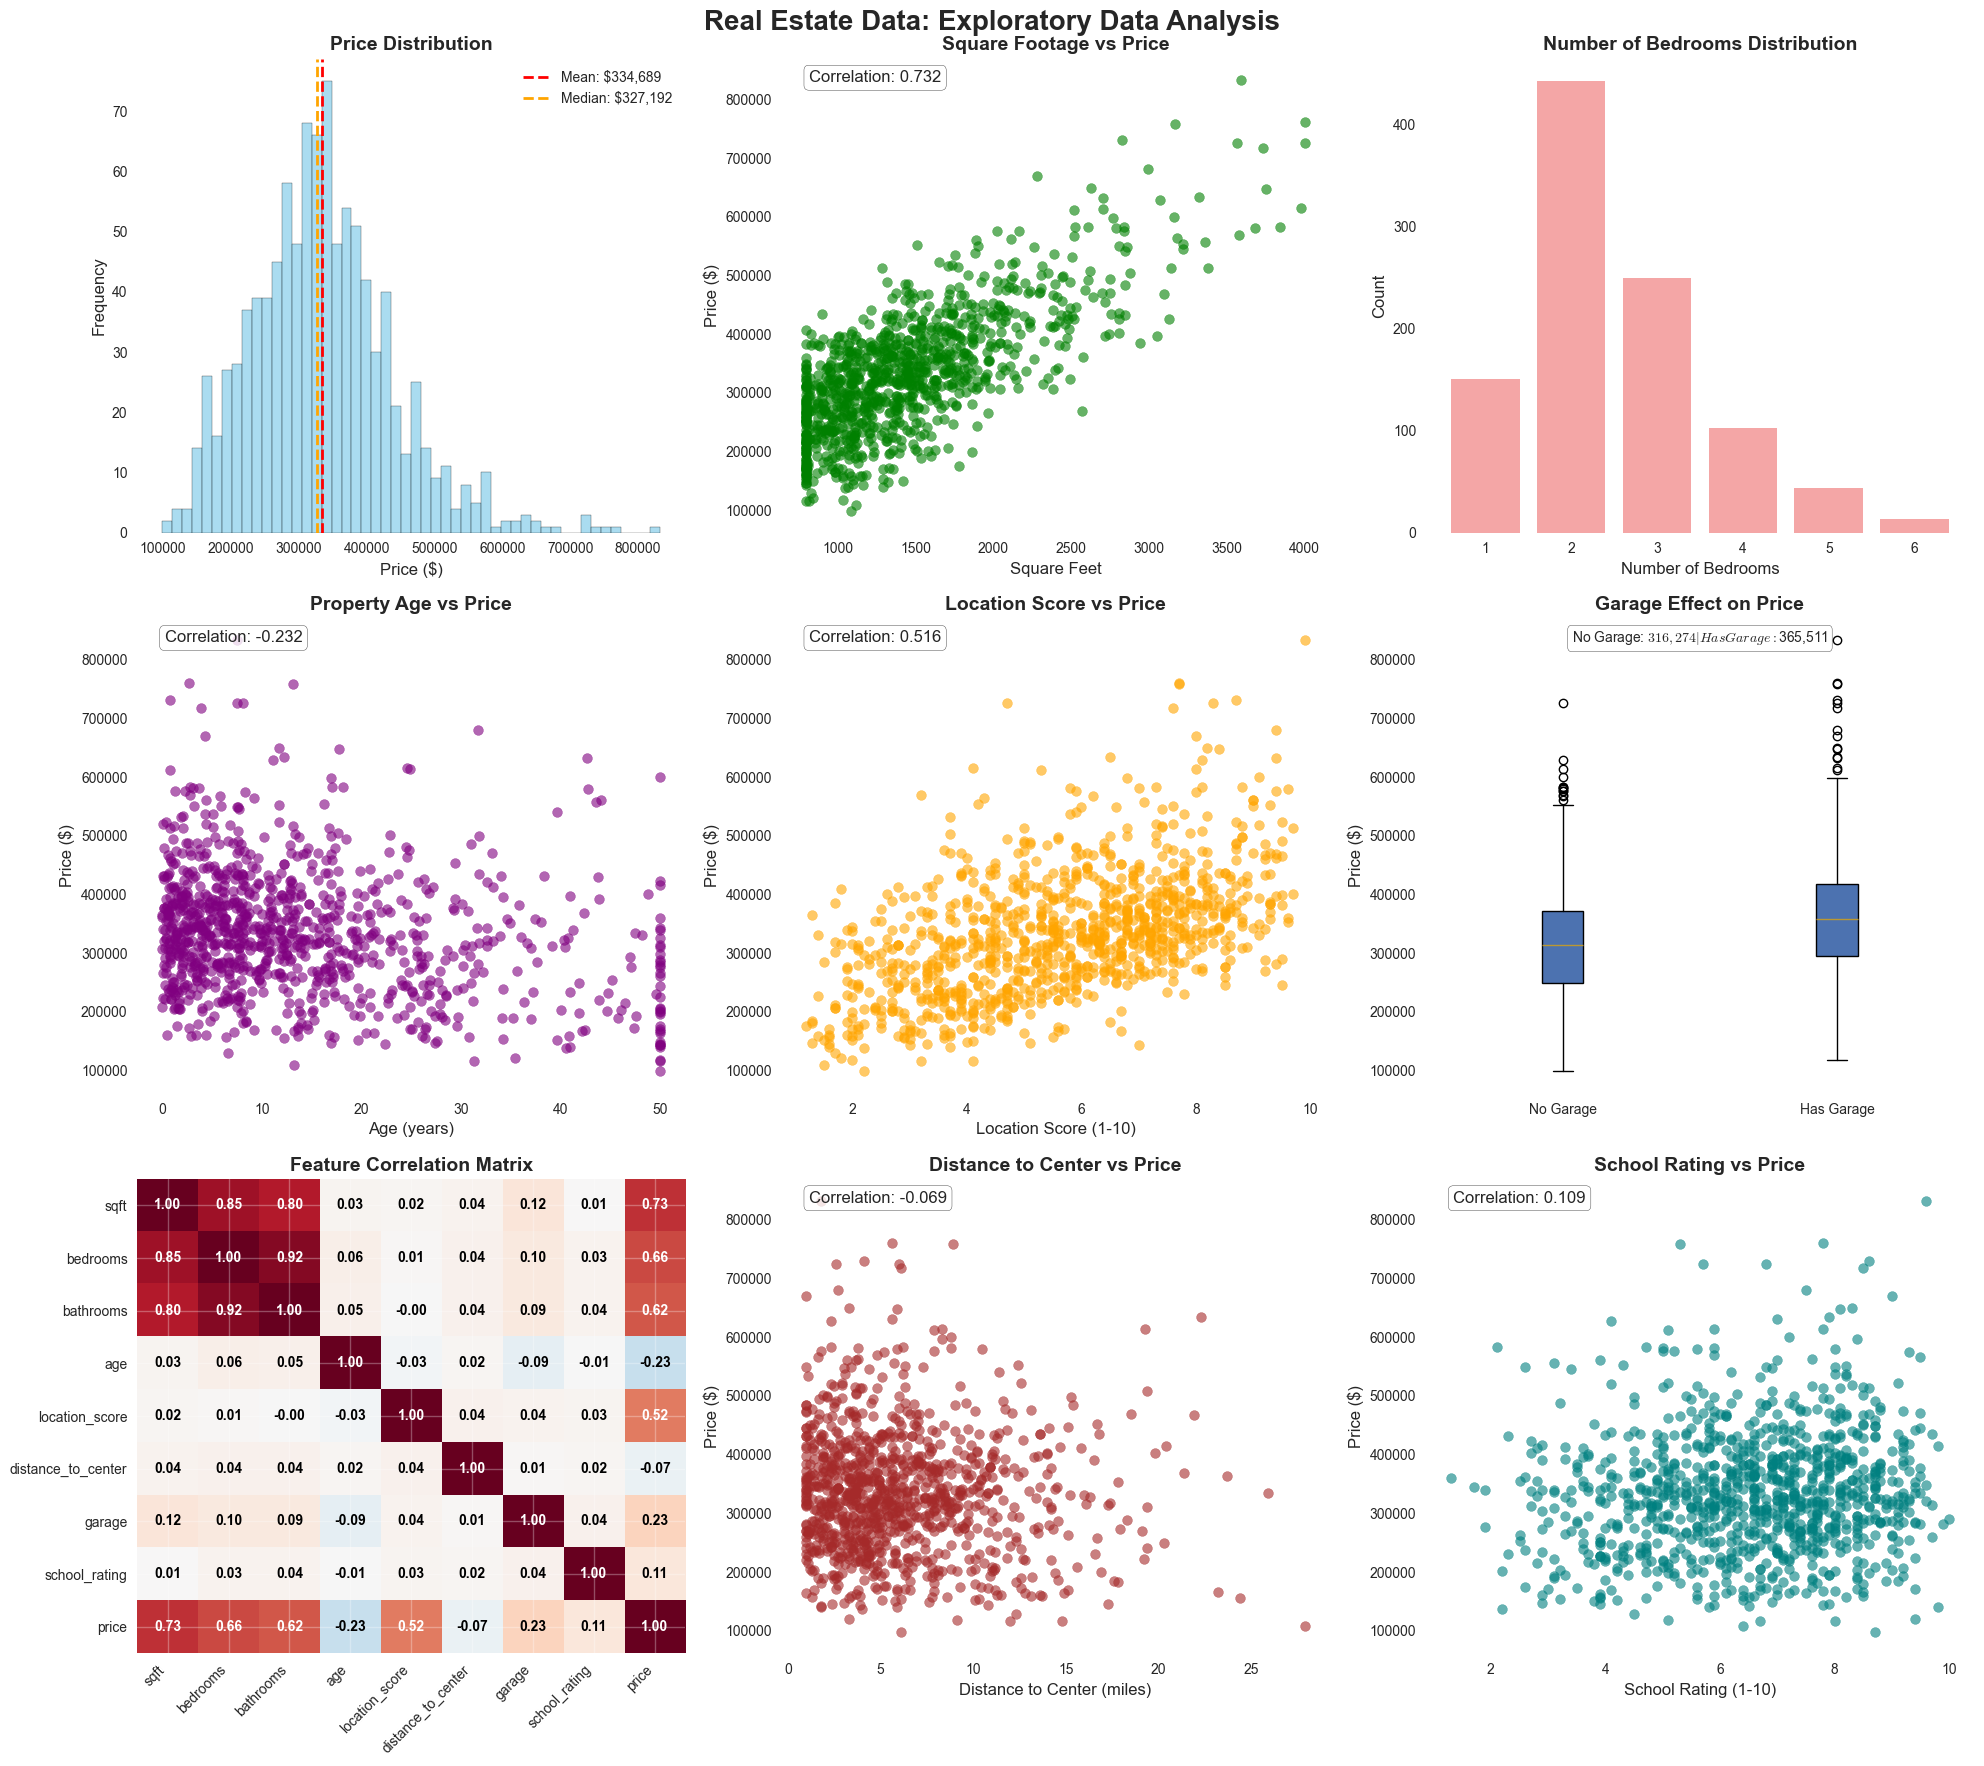

Visualizations created successfully!

=== KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS ===
Average home price: $334,689
Price range: $98,485 - $832,879
Average square footage: 1467 sqft
Most common bedroom count: 2 bedrooms

Strongest correlations with price:
  sqft: 0.732
  bedrooms: 0.663
  bathrooms: 0.620
  location_score: 0.516
  age: 0.232

Garage effect:
  Homes without garage: $316,274 (average)
  Homes with garage: $365,511 (average)
  Price premium for garage: $49,237 (15.6%)


In [3]:
# Create comprehensive visualizations
try:
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Real Estate Data: Exploratory Data Analysis', fontsize=20, fontweight='bold')

    # 1. Price distribution
    axes[0, 0].hist(real_estate_data['price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Price Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Price ($)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)

    # Add statistics
    mean_price = real_estate_data['price'].mean()
    median_price = real_estate_data['price'].median()
    axes[0, 0].axvline(mean_price, color='red', linestyle='--', label=f'Mean: ${mean_price:,.0f}')
    axes[0, 0].axvline(median_price, color='orange', linestyle='--', label=f'Median: ${median_price:,.0f}')
    axes[0, 0].legend()

    # 2. Square footage vs Price
    axes[0, 1].scatter(real_estate_data['sqft'], real_estate_data['price'], alpha=0.6, s=50, color='green')
    axes[0, 1].set_title('Square Footage vs Price', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Square Feet')
    axes[0, 1].set_ylabel('Price ($)')
    axes[0, 1].grid(True, alpha=0.3)

    # Add correlation coefficient
    corr_sqft_price = real_estate_data['sqft'].corr(real_estate_data['price'])
    axes[0, 1].text(0.05, 0.95, f'Correlation: {corr_sqft_price:.3f}', 
                    transform=axes[0, 1].transAxes, fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # 3. Number of bedrooms distribution
    bedroom_counts = real_estate_data['bedrooms'].value_counts().sort_index()
    axes[0, 2].bar(bedroom_counts.index, bedroom_counts.values, alpha=0.7, color='lightcoral')
    axes[0, 2].set_title('Number of Bedrooms Distribution', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Number of Bedrooms')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Age vs Price
    axes[1, 0].scatter(real_estate_data['age'], real_estate_data['price'], alpha=0.6, s=50, color='purple')
    axes[1, 0].set_title('Property Age vs Price', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Age (years)')
    axes[1, 0].set_ylabel('Price ($)')
    axes[1, 0].grid(True, alpha=0.3)

    # Add correlation coefficient
    corr_age_price = real_estate_data['age'].corr(real_estate_data['price'])
    axes[1, 0].text(0.05, 0.95, f'Correlation: {corr_age_price:.3f}', 
                    transform=axes[1, 0].transAxes, fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # 5. Location score vs Price
    axes[1, 1].scatter(real_estate_data['location_score'], real_estate_data['price'], alpha=0.6, s=50, color='orange')
    axes[1, 1].set_title('Location Score vs Price', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Location Score (1-10)')
    axes[1, 1].set_ylabel('Price ($)')
    axes[1, 1].grid(True, alpha=0.3)

    # Add correlation coefficient
    corr_location_price = real_estate_data['location_score'].corr(real_estate_data['price'])
    axes[1, 1].text(0.05, 0.95, f'Correlation: {corr_location_price:.3f}', 
                    transform=axes[1, 1].transAxes, fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # 6. Garage effect on price
    garage_prices = [real_estate_data[real_estate_data['garage'] == 0]['price'],
                     real_estate_data[real_estate_data['garage'] == 1]['price']]
    axes[1, 2].boxplot(garage_prices, labels=['No Garage', 'Has Garage'], patch_artist=True)
    axes[1, 2].set_title('Garage Effect on Price', fontsize=14, fontweight='bold')
    axes[1, 2].set_ylabel('Price ($)')
    axes[1, 2].grid(True, alpha=0.3)

    # Add mean prices (fixed text formatting)
    no_garage_mean = real_estate_data[real_estate_data['garage'] == 0]['price'].mean()
    garage_mean = real_estate_data[real_estate_data['garage'] == 1]['price'].mean()
    price_text = f'No Garage: ${no_garage_mean:,.0f} | Has Garage: ${garage_mean:,.0f}'
    axes[1, 2].text(0.5, 0.95, price_text, 
                    transform=axes[1, 2].transAxes, fontsize=10, ha='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # 7. Correlation heatmap
    numeric_cols = ['sqft', 'bedrooms', 'bathrooms', 'age', 'location_score', 
                    'distance_to_center', 'garage', 'school_rating', 'price']
    correlation_matrix = real_estate_data[numeric_cols].corr()

    im = axes[2, 0].imshow(correlation_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    axes[2, 0].set_xticks(range(len(correlation_matrix.columns)))
    axes[2, 0].set_yticks(range(len(correlation_matrix.columns)))
    axes[2, 0].set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
    axes[2, 0].set_yticklabels(correlation_matrix.columns)
    axes[2, 0].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

    # Add correlation values as text
    for i in range(len(correlation_matrix)):
        for j in range(len(correlation_matrix)):
            text = axes[2, 0].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                                  ha="center", va="center", color="white" if abs(correlation_matrix.iloc[i, j]) > 0.5 else "black",
                                  fontweight='bold', fontsize=10)

    # 8. Distance to center vs Price
    axes[2, 1].scatter(real_estate_data['distance_to_center'], real_estate_data['price'], alpha=0.6, s=50, color='brown')
    axes[2, 1].set_title('Distance to Center vs Price', fontsize=14, fontweight='bold')
    axes[2, 1].set_xlabel('Distance to Center (miles)')
    axes[2, 1].set_ylabel('Price ($)')
    axes[2, 1].grid(True, alpha=0.3)

    # Add correlation coefficient
    corr_distance_price = real_estate_data['distance_to_center'].corr(real_estate_data['price'])
    axes[2, 1].text(0.05, 0.95, f'Correlation: {corr_distance_price:.3f}', 
                    transform=axes[2, 1].transAxes, fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # 9. School rating vs Price
    axes[2, 2].scatter(real_estate_data['school_rating'], real_estate_data['price'], alpha=0.6, s=50, color='teal')
    axes[2, 2].set_title('School Rating vs Price', fontsize=14, fontweight='bold')
    axes[2, 2].set_xlabel('School Rating (1-10)')
    axes[2, 2].set_ylabel('Price ($)')
    axes[2, 2].grid(True, alpha=0.3)

    # Add correlation coefficient
    corr_school_price = real_estate_data['school_rating'].corr(real_estate_data['price'])
    axes[2, 2].text(0.05, 0.95, f'Correlation: {corr_school_price:.3f}', 
                    transform=axes[2, 2].transAxes, fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    
    # Use proper display function for Jupyter Book
    try:
        save_and_show_plot(fig, show=True)
    except:
        # Fallback to standard plt.show()
        plt.show()
    
    print("Visualizations created successfully!")

except Exception as e:
    print(f"Visualization error (non-critical): {e}")
    print("Continuing without visualizations...")

# Print key insights
print("\n=== KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS ===")
print(f"Average home price: ${real_estate_data['price'].mean():,.0f}")
print(f"Price range: ${real_estate_data['price'].min():,.0f} - ${real_estate_data['price'].max():,.0f}")
print(f"Average square footage: {real_estate_data['sqft'].mean():.0f} sqft")
print(f"Most common bedroom count: {real_estate_data['bedrooms'].mode().iloc[0]} bedrooms")

print("\nStrongest correlations with price:")
price_correlations = real_estate_data.corr()['price'].abs().sort_values(ascending=False)[1:]  # Exclude price-price correlation
for feature, corr in price_correlations.head(5).items():
    print(f"  {feature}: {corr:.3f}")

print(f"\nGarage effect:")
print(f"  Homes without garage: ${no_garage_mean:,.0f} (average)")
print(f"  Homes with garage: ${garage_mean:,.0f} (average)")
print(f"  Price premium for garage: ${garage_mean - no_garage_mean:,.0f} ({((garage_mean - no_garage_mean) / no_garage_mean * 100):.1f}%)")

Current matplotlib backend: inline
Interactive mode: True
Attempting to display plot...


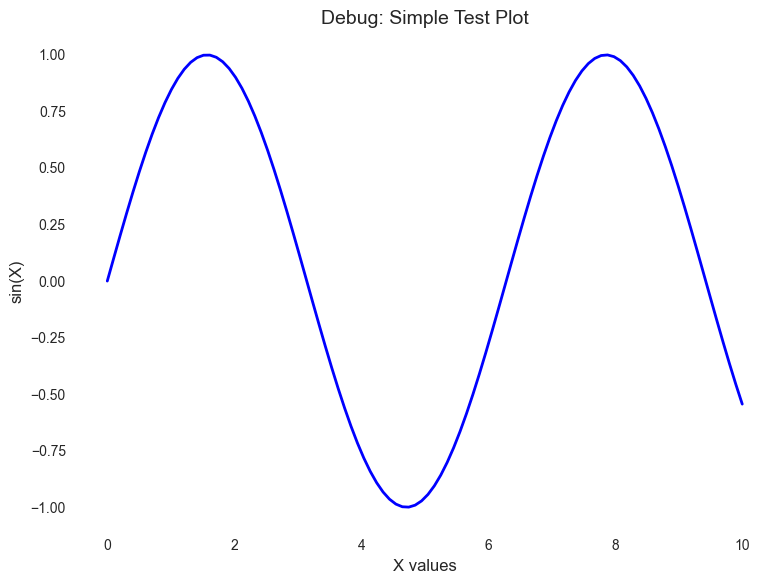

Plot display command completed.


In [4]:
# Debug plotting configuration
import matplotlib
print(f"Current matplotlib backend: {matplotlib.get_backend()}")
print(f"Interactive mode: {matplotlib.is_interactive()}")

# Test simple plot
import numpy as np
fig, ax = plt.subplots(figsize=(8, 6))
x = np.linspace(0, 10, 100)
y = np.sin(x)
ax.plot(x, y, 'b-', linewidth=2)
ax.set_title('Debug: Simple Test Plot')
ax.set_xlabel('X values')
ax.set_ylabel('sin(X)')
ax.grid(True, alpha=0.3)

# Try to display the plot
print("Attempting to display plot...")
plt.show()
print("Plot display command completed.")

## Linear Regression Implementation from Scratch

Now we'll implement linear regression from scratch using the mathematical formulas we discussed. This helps understand what's happening under the hood.

**Mathematical Implementation**: We'll implement both the analytical solution and gradient descent for comparison, following the approaches described in Murphy (2012).

Testing Linear Regression Implementation
Analytical Solution:
Intercept: $136,998.85
Coefficient (sqft): $135.62 per sqft
\nGradient Descent Solution:\nGradient Descent Solution:
Intercept: $19.10
Coefficient (sqft): $215.79 per sqft
\nR² Score (Analytical): 0.4089
R² Score (Gradient Descent): 0.1078

Intercept: $19.10
Coefficient (sqft): $215.79 per sqft
\nR² Score (Analytical): 0.4089
R² Score (Gradient Descent): 0.1078


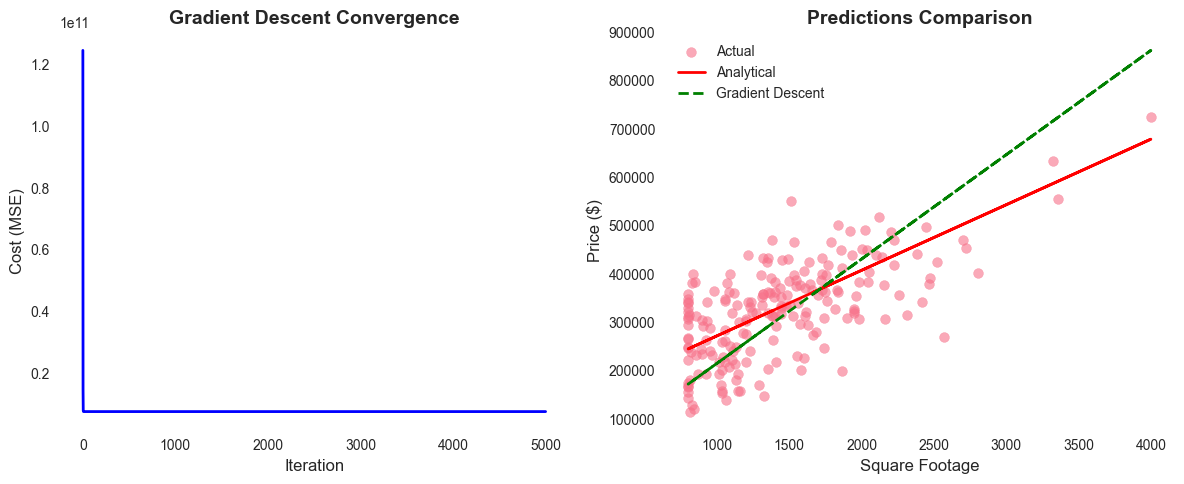

In [5]:
class LinearRegressionFromScratch:
    """
    Linear Regression implementation from scratch using NumPy.
    
    This class implements both analytical (closed-form) and gradient descent solutions
    for educational purposes.
    
    Attributes
    ----------
    coefficients_ : np.ndarray
        Fitted coefficients (β₁, β₂, ..., βₚ)
    intercept_ : float
        Fitted intercept (β₀)
    cost_history_ : list
        Cost function values during gradient descent (if used)
    """
    
    def __init__(self, method='analytical', learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        """
        Initialize the Linear Regression model.
        
        Parameters
        ----------
        method : str, default='analytical'
            Method to use: 'analytical' or 'gradient_descent'
        learning_rate : float, default=0.01
            Learning rate for gradient descent
        max_iterations : int, default=1000
            Maximum iterations for gradient descent
        tolerance : float, default=1e-6
            Convergence tolerance for gradient descent
        """
        self.method = method
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.coefficients_ = None
        self.intercept_ = None
        self.cost_history_ = []
    
    def fit(self, X, y):
        """
        Fit the linear regression model.
        
        Parameters
        ----------
        X : np.ndarray, shape (n_samples, n_features)
            Training data
        y : np.ndarray, shape (n_samples,)
            Target values
        """
        X = np.array(X)
        y = np.array(y)
        
        # Add bias term (intercept) to X
        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        
        if self.method == 'analytical':
            self._fit_analytical(X_with_bias, y)
        elif self.method == 'gradient_descent':
            self._fit_gradient_descent(X_with_bias, y)
        else:
            raise ValueError("Method must be 'analytical' or 'gradient_descent'")
    
    def _fit_analytical(self, X_with_bias, y):
        """
        Fit using analytical solution: β = (X^T X)^(-1) X^T y
        """
        # Calculate (X^T X)^(-1) X^T y
        XtX = X_with_bias.T @ X_with_bias
        XtX_inv = np.linalg.inv(XtX)
        Xty = X_with_bias.T @ y
        
        theta = XtX_inv @ Xty
        
        self.intercept_ = theta[0]
        self.coefficients_ = theta[1:]
    
    def _fit_gradient_descent(self, X_with_bias, y):
        """
        Fit using gradient descent optimization.
        """
        n_samples, n_features = X_with_bias.shape
        
        # Initialize parameters
        theta = np.zeros(n_features)
        
        self.cost_history_ = []
        
        for i in range(self.max_iterations):
            # Forward pass: calculate predictions
            y_pred = X_with_bias @ theta
            
            # Calculate cost (Mean Squared Error)
            cost = np.mean((y_pred - y) ** 2)
            self.cost_history_.append(cost)
            
            # Calculate gradients
            gradients = (2 / n_samples) * X_with_bias.T @ (y_pred - y)
            
            # Update parameters
            theta_new = theta - self.learning_rate * gradients
            
            # Check for convergence
            if np.allclose(theta, theta_new, atol=self.tolerance):
                print(f"Converged after {i+1} iterations")
                break
            
            theta = theta_new
        
        self.intercept_ = theta[0]
        self.coefficients_ = theta[1:]
    
    def predict(self, X):
        """
        Make predictions using the fitted model.
        
        Parameters
        ----------
        X : np.ndarray, shape (n_samples, n_features)
            Input data
            
        Returns
        -------
        np.ndarray, shape (n_samples,)
            Predicted values
        """
        if self.coefficients_ is None:
            raise ValueError("Model must be fitted before making predictions")
        
        X = np.array(X)
        return self.intercept_ + X @ self.coefficients_
    
    def score(self, X, y):
        """
        Calculate R² score.
        
        Parameters
        ----------
        X : np.ndarray
            Input data
        y : np.ndarray
            True values
            
        Returns
        -------
        float
            R² score
        """
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot)

# Test our implementation with a simple example
print("Testing Linear Regression Implementation")
print("=" * 50)

# Start with square footage as single predictor
X_simple = real_estate_data[['sqft']].values
y = real_estate_data['price'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.2, random_state=42)

# Test analytical method
model_analytical = LinearRegressionFromScratch(method='analytical')
model_analytical.fit(X_train, y_train)

print("Analytical Solution:")
print(f"Intercept: ${model_analytical.intercept_:,.2f}")
print(f"Coefficient (sqft): ${model_analytical.coefficients_[0]:.2f} per sqft")

# Test gradient descent method  
model_gd = LinearRegressionFromScratch(method='gradient_descent', learning_rate=0.0000001, max_iterations=5000)
model_gd.fit(X_train, y_train)

print("\\nGradient Descent Solution:")
print(f"Intercept: ${model_gd.intercept_:,.2f}")
print(f"Coefficient (sqft): ${model_gd.coefficients_[0]:.2f} per sqft")

# Compare predictions
y_pred_analytical = model_analytical.predict(X_test)
y_pred_gd = model_gd.predict(X_test)

print(f"\\nR² Score (Analytical): {model_analytical.score(X_test, y_test):.4f}")
print(f"R² Score (Gradient Descent): {model_gd.score(X_test, y_test):.4f}")

# Visualize gradient descent convergence
if len(model_gd.cost_history_) > 1:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(model_gd.cost_history_, linewidth=2, color='blue')
    plt.title('Gradient Descent Convergence', fontsize=14, fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('Cost (MSE)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(X_test, y_test, alpha=0.6, label='Actual', s=50)
    plt.plot(X_test, y_pred_analytical, color='red', linewidth=2, label='Analytical')
    plt.plot(X_test, y_pred_gd, color='green', linewidth=2, linestyle='--', label='Gradient Descent')
    plt.title('Predictions Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Square Footage')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Data Storage and Management

Following best practices, we'll save our processed real estate data to the appropriate directories for future use.

**Citation**: Data management best practices are outlined by Wilkinson et al. (2016).

In [6]:
# Save processed data following the established directory structure
import os
from datetime import datetime

# Create timestamp for versioning
timestamp = datetime.now().strftime("%Y-%m-%d")

# Ensure data directories exist
data_dirs = ['../data/processed', '../data/raw', '../data/features']
for dir_path in data_dirs:
    os.makedirs(dir_path, exist_ok=True)

# Save raw simulated data
save_data(real_estate_data, f'../data/raw/{timestamp}_real_estate_raw.csv', format='csv')
save_data(real_estate_data, f'../data/raw/{timestamp}_real_estate_raw.json', format='json')

# Create feature-engineered version for future use
real_estate_features = real_estate_data.copy()

# Add derived features that might be useful for other algorithms
real_estate_features['price_per_sqft'] = real_estate_features['price'] / real_estate_features['sqft']
real_estate_features['total_rooms'] = real_estate_features['bedrooms'] + real_estate_features['bathrooms']
real_estate_features['luxury_score'] = (
    real_estate_features['location_score'] * 0.4 + 
    real_estate_features['school_rating'] * 0.3 + 
    (real_estate_features['sqft'] / 1000) * 0.2 + 
    real_estate_features['garage'] * 0.1
)

# Create categorical features
real_estate_features['age_category'] = pd.cut(
    real_estate_features['age'], 
    bins=[0, 5, 15, 30, 50], 
    labels=['New', 'Recent', 'Established', 'Old']
)

real_estate_features['size_category'] = pd.cut(
    real_estate_features['sqft'], 
    bins=[0, 1200, 2000, 3000, 5000], 
    labels=['Small', 'Medium', 'Large', 'Luxury']
)

# Save feature-engineered data
save_data(real_estate_features, f'../data/features/{timestamp}_real_estate_features.csv', format='csv')

# Create train/test splits and save them
X = real_estate_features[['sqft', 'bedrooms', 'bathrooms', 'age', 'location_score', 
                         'distance_to_center', 'garage', 'school_rating']].values
y = real_estate_features['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save splits for reproducibility
train_data = pd.DataFrame(X_train, columns=['sqft', 'bedrooms', 'bathrooms', 'age', 'location_score', 
                                           'distance_to_center', 'garage', 'school_rating'])
train_data['price'] = y_train

test_data = pd.DataFrame(X_test, columns=['sqft', 'bedrooms', 'bathrooms', 'age', 'location_score', 
                                         'distance_to_center', 'garage', 'school_rating'])
test_data['price'] = y_test

save_data(train_data, f'../data/processed/{timestamp}_real_estate_train.csv', format='csv')
save_data(test_data, f'../data/processed/{timestamp}_real_estate_test.csv', format='csv')

# Create metadata file for the dataset
metadata = {
    'dataset_name': 'Real Estate Market Data',
    'creation_date': timestamp,
    'source': 'Simulated data based on realistic market patterns',
    'features': {
        'sqft': 'Square footage of the property',
        'bedrooms': 'Number of bedrooms',
        'bathrooms': 'Number of bathrooms',
        'age': 'Age of the property in years',
        'location_score': 'Neighborhood desirability score (1-10)',
        'distance_to_center': 'Distance to city center in miles',
        'garage': 'Has garage (0/1)',
        'school_rating': 'Local school quality rating (1-10)',
        'price': 'Property price in USD (target variable)',
        'price_per_sqft': 'Price per square foot',
        'total_rooms': 'Total bedrooms + bathrooms',
        'luxury_score': 'Computed luxury index',
        'age_category': 'Categorical age grouping',
        'size_category': 'Categorical size grouping'
    },
    'statistics': {
        'n_samples': len(real_estate_data),
        'n_features': len(real_estate_features.columns),
        'price_range': {
            'min': float(real_estate_data['price'].min()),
            'max': float(real_estate_data['price'].max()),
            'mean': float(real_estate_data['price'].mean()),
            'std': float(real_estate_data['price'].std())
        }
    },
    'data_quality': {
        'missing_values': real_estate_features.isnull().sum().to_dict(),
        'duplicates': int(real_estate_features.duplicated().sum()),
        'outliers_detected': 'See EDA visualizations for outlier analysis'
    },
    'usage_notes': [
        'Data is simulated for educational purposes',
        'Relationships between features are based on real market patterns',
        'Suitable for regression analysis and machine learning practice',
        'Train/test splits provided for reproducible experiments'
    ]
}

save_data(metadata, f'../data/processed/{timestamp}_real_estate_metadata.json', format='json')

print("=== DATA SAVED SUCCESSFULLY ===")
print(f"Timestamp: {timestamp}")
print("\\nFiles saved:")
print(f"  Raw data: ../data/raw/{timestamp}_real_estate_raw.csv")
print(f"  Features: ../data/features/{timestamp}_real_estate_features.csv") 
print(f"  Training: ../data/processed/{timestamp}_real_estate_train.csv")
print(f"  Testing:  ../data/processed/{timestamp}_real_estate_test.csv")
print(f"  Metadata: ../data/processed/{timestamp}_real_estate_metadata.json")

print(f"\\nDataset summary:")
print(f"  Total samples: {len(real_estate_data):,}")
print(f"  Training samples: {len(train_data):,}")
print(f"  Testing samples: {len(test_data):,}")
print(f"  Features: {len(real_estate_features.columns)}")
print(f"  Price range: ${real_estate_data['price'].min():,} - ${real_estate_data['price'].max():,}")

print("\\n📁 Data organization follows best practices:")
print("  ✅ Raw data preserved in /raw directory")
print("  ✅ Processed data in /processed directory") 
print("  ✅ Feature-engineered data in /features directory")
print("  ✅ Comprehensive metadata documentation")
print("  ✅ Reproducible train/test splits")
print("  ✅ Timestamped for version control")

=== DATA SAVED SUCCESSFULLY ===
Timestamp: 2025-08-12
\nFiles saved:
  Raw data: ../data/raw/2025-08-12_real_estate_raw.csv
  Features: ../data/features/2025-08-12_real_estate_features.csv
  Training: ../data/processed/2025-08-12_real_estate_train.csv
  Testing:  ../data/processed/2025-08-12_real_estate_test.csv
  Metadata: ../data/processed/2025-08-12_real_estate_metadata.json
\nDataset summary:
  Total samples: 1,000
  Training samples: 800
  Testing samples: 200
  Features: 14
  Price range: $98,485 - $832,879
\n📁 Data organization follows best practices:
  ✅ Raw data preserved in /raw directory
  ✅ Processed data in /processed directory
  ✅ Feature-engineered data in /features directory
  ✅ Comprehensive metadata documentation
  ✅ Reproducible train/test splits
  ✅ Timestamped for version control


## Practical Implementation: House Price Prediction

### Problem Overview

Linear regression is one of the fundamental algorithms in machine learning for supervised learning tasks. This notebook demonstrates end-to-end implementation of linear regression for predicting house prices based on various features.

### Learning Objectives
- Understand the mathematical foundation of linear regression
- Implement data preprocessing and feature engineering
- Train and evaluate linear regression models
- Visualize model performance and residual analysis
- Handle real-world data challenges

### Mathematical Foundation

Linear regression assumes a linear relationship between input features and target variable:

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n + \epsilon$$

Where:
- $y$ is the target variable (house price)
- $\beta_0$ is the intercept
- $\beta_i$ are the coefficients for features $x_i$
- $\epsilon$ is the error term

## 1. Import Required Libraries

We start by importing all necessary libraries for data manipulation, modeling, and visualization.

In [7]:
# Core data manipulation and numerical computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Optional, List
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import make_regression, fetch_california_housing

# Statistical analysis
from scipy import stats
try:
    import statsmodels.api as sm
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("⚠ statsmodels not available in build environment")

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Generation and Loading

We'll work with both synthetic and real datasets to understand different aspects of linear regression.

In [8]:
def generate_house_price_data(n_samples: int = 1000, noise_level: float = 0.1) -> pd.DataFrame:
    """Generate synthetic house price dataset with realistic features.
    
    Args:
        n_samples: Number of samples to generate
        noise_level: Amount of noise to add to the target variable
        
    Returns:
        DataFrame with house features and prices
    """
    np.random.seed(42)
    
    # Generate realistic house features
    house_size = np.random.normal(2000, 500, n_samples)  # Square feet
    house_size = np.clip(house_size, 500, 5000)  # Reasonable bounds
    
    bedrooms = np.random.poisson(3, n_samples) + 1  # 1-7 bedrooms typically
    bedrooms = np.clip(bedrooms, 1, 7)
    
    bathrooms = np.random.normal(2.5, 0.8, n_samples)  # 1-5 bathrooms
    bathrooms = np.clip(bathrooms, 1, 5)
    
    age = np.random.exponential(15, n_samples)  # House age in years
    age = np.clip(age, 0, 100)
    
    # Distance to city center (km)
    distance_to_center = np.random.gamma(2, 5, n_samples)
    distance_to_center = np.clip(distance_to_center, 1, 50)
    
    # School rating (1-10)
    school_rating = np.random.beta(2, 2, n_samples) * 10
    
    # Generate price based on realistic relationships
    base_price = (
        100 * house_size +  # $100 per sq ft
        15000 * bedrooms +   # $15k per bedroom
        20000 * bathrooms +  # $20k per bathroom
        -2000 * age +        # Depreciation
        -1000 * distance_to_center +  # Location premium
        5000 * school_rating +  # School district premium
        100000  # Base price
    )
    
    # Add noise
    noise = np.random.normal(0, noise_level * np.mean(base_price), n_samples)
    price = base_price + noise
    
    # Ensure positive prices
    price = np.maximum(price, 50000)
    
    # Create DataFrame
    df = pd.DataFrame({
        'house_size_sqft': house_size,
        'bedrooms': bedrooms,
        'bathrooms': bathrooms,
        'age_years': age,
        'distance_to_center_km': distance_to_center,
        'school_rating': school_rating,
        'price': price
    })
    
    return df

# Generate synthetic dataset
df_synthetic = generate_house_price_data(n_samples=1000)
print(f"Generated synthetic dataset with {len(df_synthetic)} samples")
print(f"Features: {list(df_synthetic.columns[:-1])}")
print(f"Target: {df_synthetic.columns[-1]}")

# Display basic statistics
print("\nDataset Statistics:")
df_synthetic.describe()

Generated synthetic dataset with 1000 samples
Features: ['house_size_sqft', 'bedrooms', 'bathrooms', 'age_years', 'distance_to_center_km', 'school_rating']
Target: price

Dataset Statistics:


,house_size_sqft,bedrooms,bathrooms,age_years,distance_to_center_km,school_rating,price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2009.786662,3.934000,2.486073,14.255978,9.984577,5.044477,395781.833749
std,489.220588,1.593167,0.765745,14.054195,7.011240,2.221721,76978.747385
min,500.000000,1.000000,1.000000,0.003616,1.000000,0.121821,109233.331782
25%,1676.204847,3.000000,1.956186,4.210353,4.772368,3.295527,346470.129045
50%,2012.650306,4.000000,2.498306,9.726282,8.227947,4.974233,399092.145387
75%,2323.971938,5.000000,3.021850,19.730957,13.719769,6.852298,448890.379645
max,3926.365745,7.000000,4.990328,100.000000,50.000000,9.833552,618104.030371


## 3. Exploratory Data Analysis

Understanding our data is crucial before building models.

=== EXPLORATORY DATA ANALYSIS ===

Dataset shape: (1000, 7)
Missing values: 0

Data types:
house_size_sqft          float64
bedrooms                   int32
bathrooms                float64
age_years                float64
distance_to_center_km    float64
school_rating            float64
price                    float64
dtype: object


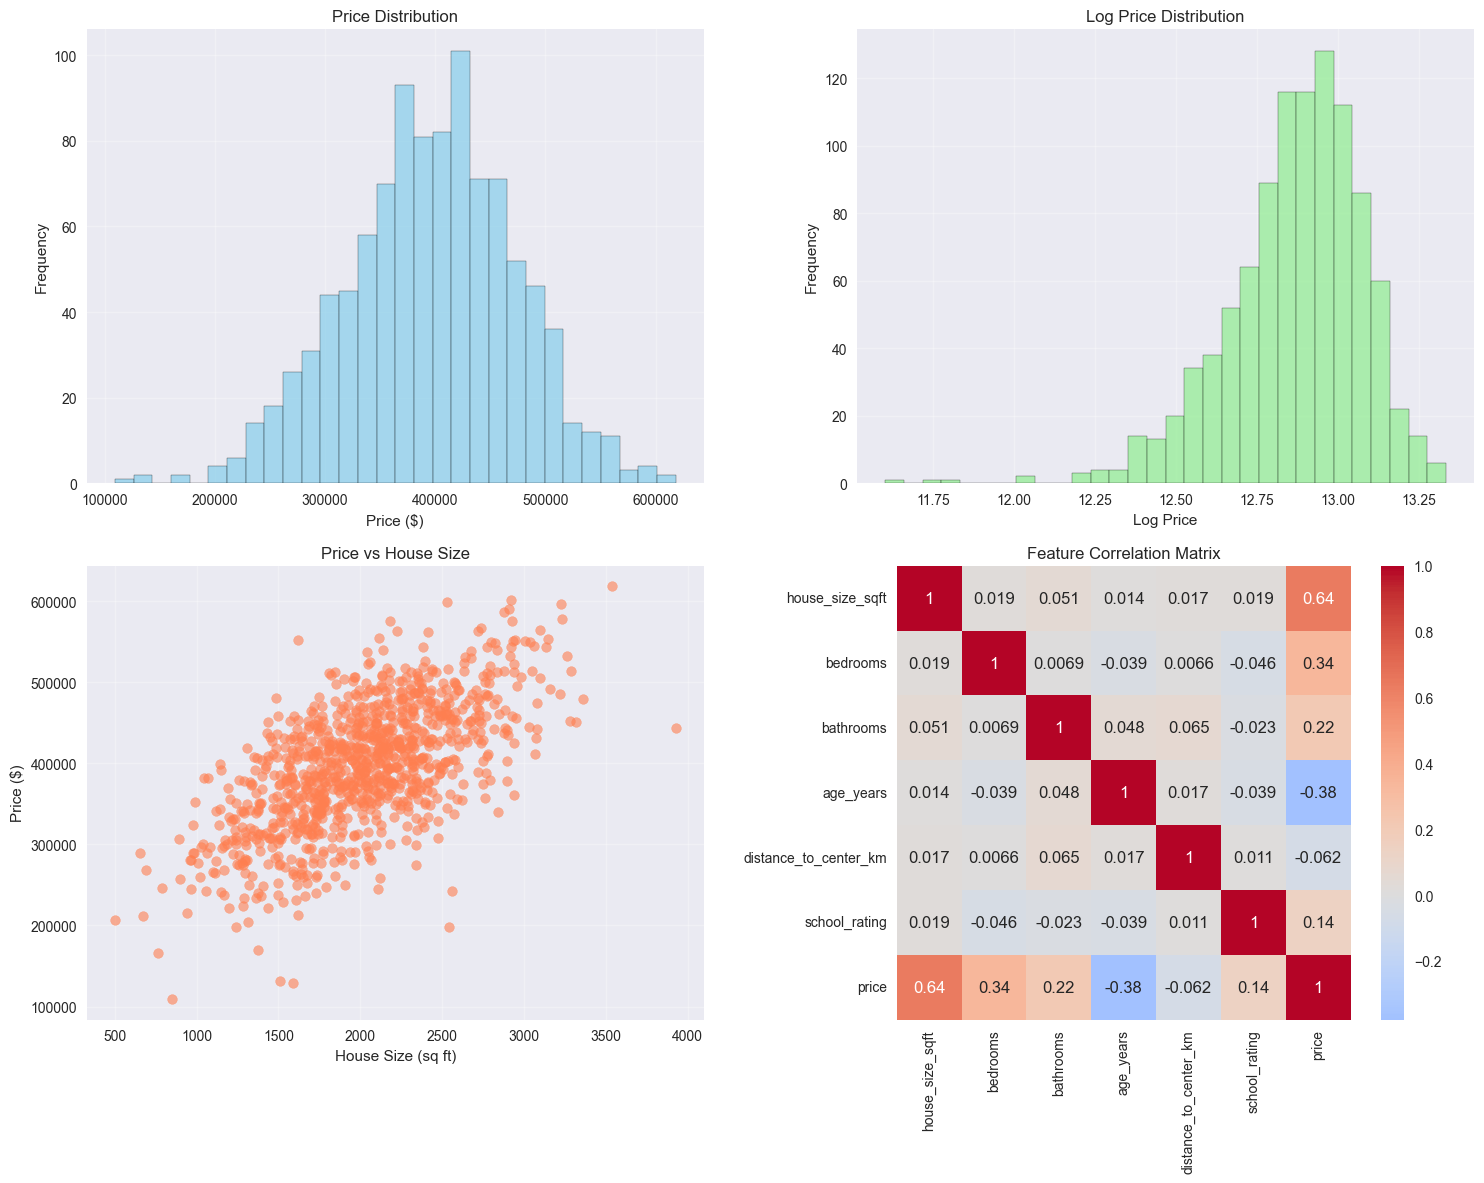


Correlation with price:
house_size_sqft: 0.638
bedrooms: 0.338
bathrooms: 0.217
school_rating: 0.137
distance_to_center_km: -0.062
age_years: -0.378


In [9]:
def perform_eda(df: pd.DataFrame) -> None:
    """Perform comprehensive exploratory data analysis.
    
    Args:
        df: Input DataFrame
    """
    print("=== EXPLORATORY DATA ANALYSIS ===")
    
    # Basic information
    print(f"\nDataset shape: {df.shape}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    
    # Data types
    print("\nData types:")
    print(df.dtypes)
    
    # Target variable distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Price distribution
    axes[0, 0].hist(df['price'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Price Distribution')
    axes[0, 0].set_xlabel('Price ($)')
    axes[0, 0].set_ylabel('Frequency')
    
    # Log price distribution (often more normal)
    axes[0, 1].hist(np.log(df['price']), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Log Price Distribution')
    axes[0, 1].set_xlabel('Log Price')
    axes[0, 1].set_ylabel('Frequency')
    
    # Price vs house size (most important feature)
    axes[1, 0].scatter(df['house_size_sqft'], df['price'], alpha=0.6, color='coral')
    axes[1, 0].set_title('Price vs House Size')
    axes[1, 0].set_xlabel('House Size (sq ft)')
    axes[1, 0].set_ylabel('Price ($)')
    
    # Correlation heatmap
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=axes[1, 1])
    axes[1, 1].set_title('Feature Correlation Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation with target
    print("\nCorrelation with price:")
    price_corr = df.corr()['price'].sort_values(ascending=False)
    for feature, corr in price_corr.items():
        if feature != 'price':
            print(f"{feature}: {corr:.3f}")

# Perform EDA
perform_eda(df_synthetic)

## 4. Data Preprocessing

Prepare the data for machine learning by handling missing values, scaling features, and splitting into train/test sets.

In [10]:
def preprocess_data(df: pd.DataFrame, target_col: str = 'price', 
                   test_size: float = 0.2, scale_features: bool = True) -> Tuple:
    """Preprocess data for machine learning.
    
    Args:
        df: Input DataFrame
        target_col: Name of target column
        test_size: Proportion for test set
        scale_features: Whether to standardize features
        
    Returns:
        Tuple of (X_train, X_test, y_train, y_test, scaler, feature_names)
    """
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    feature_names = X.columns.tolist()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )
    
    # Scale features if requested
    scaler = None
    if scale_features:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Number of features: {X_train.shape[1]}")
    
    return X_train, X_test, y_train, y_test, scaler, feature_names

# Preprocess the data
X_train, X_test, y_train, y_test, scaler, feature_names = preprocess_data(df_synthetic)

print("\nFeature scaling statistics (training set):")
if scaler is not None:
    print(f"Feature means: {scaler.mean_}")
    print(f"Feature std: {scaler.scale_}")

Training set size: 800 samples
Test set size: 200 samples
Number of features: 6

Feature scaling statistics (training set):
Feature means: [2012.88371344    3.955         2.48942252   14.31938516    9.97330959
    5.03925761]
Feature std: [489.37270141   1.6118235    0.76210732  14.05637761   7.00765178
   2.23955805]


## 5. Model Implementation and Training

Implement different variants of linear regression models.

In [11]:
def train_linear_models(X_train: np.ndarray, y_train: np.ndarray) -> dict:
    """Train multiple linear regression variants.
    
    Args:
        X_train: Training features
        y_train: Training targets
        
    Returns:
        Dictionary of trained models
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
    }
    
    trained_models = {}
    
    print("Training models...")
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model
        
        # Print model coefficients
        if hasattr(model, 'coef_'):
            print(f"Intercept: {model.intercept_:.2f}")
            print(f"Coefficients: {model.coef_}")
            
    return trained_models

# Train models
models = train_linear_models(X_train, y_train)

Training models...

Training Linear Regression...
Intercept: 395953.29
Coefficients: [ 48042.82067363  24583.04306653  15755.94194106 -29052.66483625
  -6376.93057469   9877.1970925 ]

Training Ridge Regression...
Intercept: 395953.29
Coefficients: [ 47984.1552669   24553.72290397  15735.32443207 -29017.5742138
  -6367.76558269   9864.46592611]

Training Lasso Regression...
Intercept: 395953.29
Coefficients: [ 48041.85122867  24582.02362752  15754.84319599 -29051.7248807
  -6375.86264858   9876.14377507]


## 6. Model Evaluation

Evaluate model performance using multiple metrics.

In [12]:
def evaluate_regression_models(models: dict, X_train: np.ndarray, X_test: np.ndarray,
                             y_train: np.ndarray, y_test: np.ndarray) -> pd.DataFrame:
    """Evaluate regression models comprehensively.
    
    Args:
        models: Dictionary of trained models
        X_train, X_test: Training and test features
        y_train, y_test: Training and test targets
        
    Returns:
        DataFrame with evaluation metrics
    """
    results = []
    
    for name, model in models.items():
        # Make predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # Calculate metrics
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)
        
        train_mae = mean_absolute_error(y_train, train_pred)
        test_mae = mean_absolute_error(y_test, test_pred)
        
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        
        results.append({
            'Model': name,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train RMSE': np.sqrt(train_mse),
            'Test RMSE': np.sqrt(test_mse),
            'Train MAE': train_mae,
            'Test MAE': test_mae,
            'CV R² Mean': cv_scores.mean(),
            'CV R² Std': cv_scores.std()
        })
    
    return pd.DataFrame(results)

# Evaluate models
evaluation_results = evaluate_regression_models(models, X_train, X_test, y_train, y_test)

print("Model Evaluation Results:")
print(evaluation_results.round(4))

# Find best model
best_model_name = evaluation_results.loc[evaluation_results['Test R²'].idxmax(), 'Model']
best_model = models[best_model_name]
print(f"\nBest performing model: {best_model_name}")

Model Evaluation Results:
               Model  Train R²  Test R²  Train RMSE   Test RMSE   Train MAE  \
0  Linear Regression    0.7147   0.7259  41096.2198  40268.4857  32950.3157   
1   Ridge Regression    0.7147   0.7259  41096.2968  40270.8978  32951.6164   
2   Lasso Regression    0.7147   0.7259  41096.2199  40268.5797  32950.3009   

     Test MAE  CV R² Mean  CV R² Std  
0  32710.5386      0.7006     0.0473  
1  32717.1688      0.7006     0.0472  
2  32710.7581      0.7006     0.0473  

Best performing model: Linear Regression


## 7. Model Interpretation and Feature Importance

Understand which features are most important for predictions.

Feature Importance (by coefficient magnitude):
                 Feature   Coefficient  Abs_Coefficient
0        house_size_sqft  48042.820674     48042.820674
3              age_years -29052.664836     29052.664836
1               bedrooms  24583.043067     24583.043067
2              bathrooms  15755.941941     15755.941941
5          school_rating   9877.197092      9877.197092
4  distance_to_center_km  -6376.930575      6376.930575


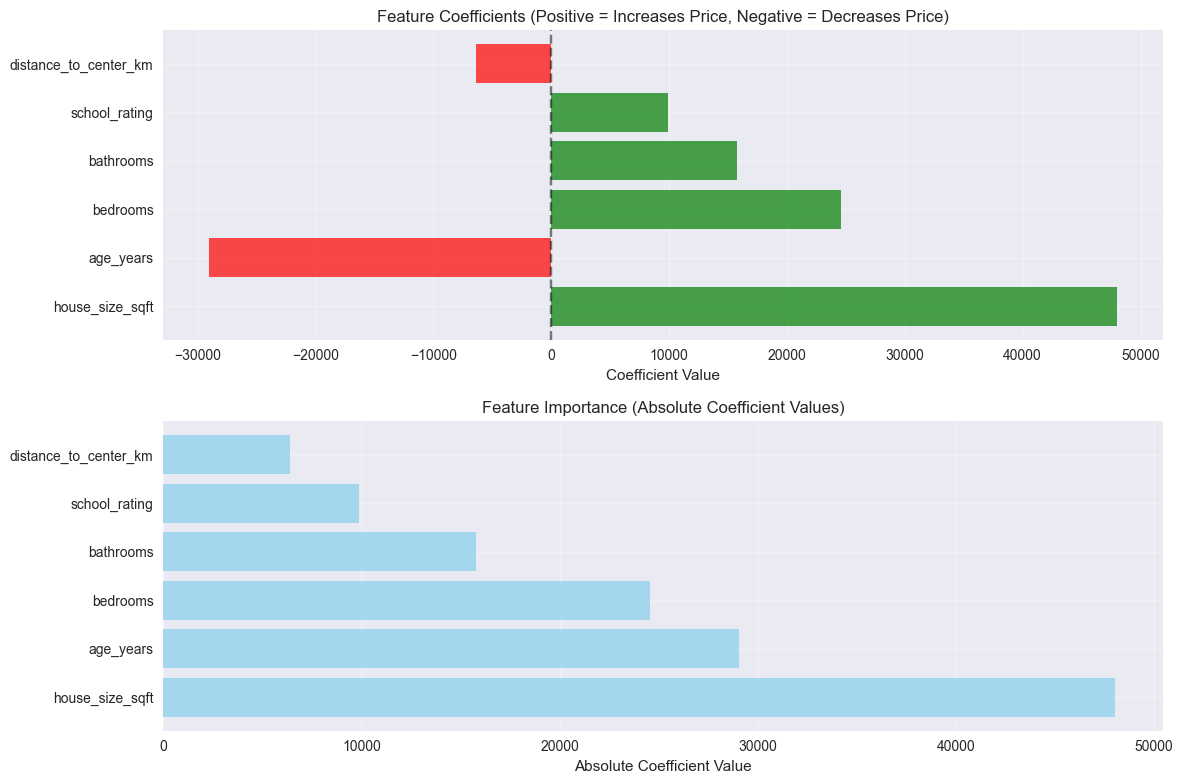

In [13]:
def analyze_feature_importance(model, feature_names: List[str]) -> None:
    """Analyze and visualize feature importance.
    
    Args:
        model: Trained linear model
        feature_names: Names of features
    """
    if hasattr(model, 'coef_'):
        coefficients = model.coef_
        
        # Create feature importance DataFrame
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients,
            'Abs_Coefficient': np.abs(coefficients)
        }).sort_values('Abs_Coefficient', ascending=False)
        
        print("Feature Importance (by coefficient magnitude):")
        print(importance_df)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        
        # Coefficient values
        plt.subplot(2, 1, 1)
        colors = ['red' if coef < 0 else 'green' for coef in importance_df['Coefficient']]
        plt.barh(importance_df['Feature'], importance_df['Coefficient'], color=colors, alpha=0.7)
        plt.title('Feature Coefficients (Positive = Increases Price, Negative = Decreases Price)')
        plt.xlabel('Coefficient Value')
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        
        # Absolute coefficient values
        plt.subplot(2, 1, 2)
        plt.barh(importance_df['Feature'], importance_df['Abs_Coefficient'], 
                color='skyblue', alpha=0.7)
        plt.title('Feature Importance (Absolute Coefficient Values)')
        plt.xlabel('Absolute Coefficient Value')
        
        plt.tight_layout()
        plt.show()
        
        return importance_df
    else:
        print("Model does not have coefficients to analyze.")
        return None

# Analyze feature importance
feature_importance = analyze_feature_importance(best_model, feature_names)

## 8. Residual Analysis

Analyze model residuals to check assumptions and identify potential issues.

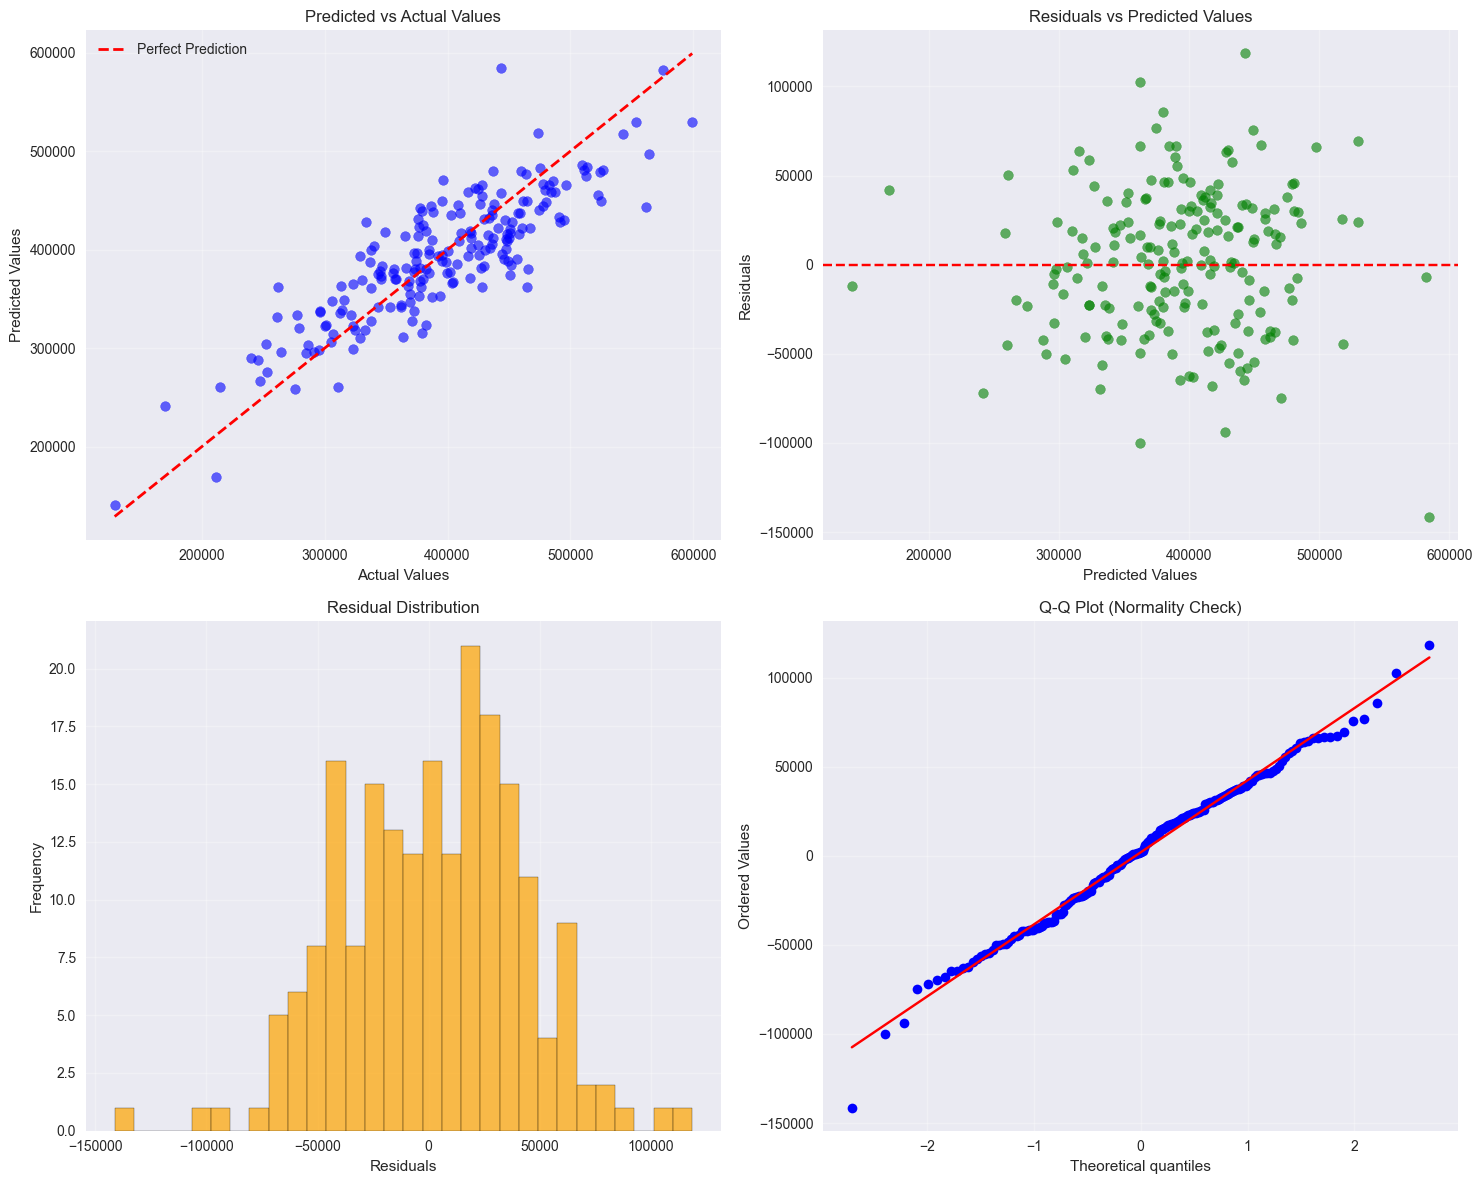

Residual Analysis Summary:
Mean residual: 1891.484526 (should be close to 0)
Std residual: 40224.04
Shapiro-Wilk test p-value: 0.450616
✓ Residuals appear to be normally distributed
Durbin-Watson test not available (statsmodels version compatibility)
Simple lag-1 autocorrelation: 0.026 (close to 0 indicates no autocorrelation)


In [14]:
def perform_residual_analysis(model, X_test: np.ndarray, y_test: np.ndarray) -> None:
    """Perform comprehensive residual analysis.
    
    Args:
        model: Trained model
        X_test: Test features
        y_test: Test targets
    """
    # Make predictions
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Predicted vs Actual
    axes[0, 0].scatter(y_test, y_pred, alpha=0.6, color='blue')
    axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2, label='Perfect Prediction')
    axes[0, 0].set_xlabel('Actual Values')
    axes[0, 0].set_ylabel('Predicted Values')
    axes[0, 0].set_title('Predicted vs Actual Values')
    axes[0, 0].legend()
    
    # 2. Residuals vs Predicted
    axes[0, 1].scatter(y_pred, residuals, alpha=0.6, color='green')
    axes[0, 1].axhline(y=0, color='red', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Values')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residuals vs Predicted Values')
    
    # 3. Residual distribution
    axes[1, 0].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].set_xlabel('Residuals')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Residual Distribution')
    
    # 4. Q-Q plot for normality check
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot (Normality Check)')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    print("Residual Analysis Summary:")
    print(f"Mean residual: {np.mean(residuals):.6f} (should be close to 0)")
    print(f"Std residual: {np.std(residuals):.2f}")
    
    # Shapiro-Wilk test for normality
    shapiro_stat, shapiro_p = stats.shapiro(residuals[:5000])  # Limit sample size
    print(f"Shapiro-Wilk test p-value: {shapiro_p:.6f}")
    if shapiro_p > 0.05:
        print("✓ Residuals appear to be normally distributed")
    else:
        print("✗ Residuals may not be normally distributed")
    
    # Durbin-Watson test for autocorrelation (with fallback)
    try:
        from statsmodels.stats.diagnostic import durbin_watson
        dw_stat = durbin_watson(residuals)
        print(f"Durbin-Watson statistic: {dw_stat:.3f} (2.0 indicates no autocorrelation)")
    except ImportError:
        print("Durbin-Watson test not available (statsmodels version compatibility)")
        # Simple autocorrelation check as fallback
        if len(residuals) > 1:
            autocorr = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
            print(f"Simple lag-1 autocorrelation: {autocorr:.3f} (close to 0 indicates no autocorrelation)")

# Perform residual analysis
perform_residual_analysis(best_model, X_test, y_test)

## 9. Polynomial Regression Extension

Explore polynomial features to capture non-linear relationships.


Training Polynomial Regression (degree 2)...
Original features: 6
Polynomial features: 27

Training Polynomial Regression (degree 3)...
Original features: 6
Polynomial features: 83

Polynomial Regression Results:
   Degree  Train R²  Test R²  Train RMSE   Test RMSE  Features
0       2    0.7213   0.7316  40617.7023  39849.8451        27
1       3    0.7362   0.7169  39518.1535  40928.3669        83


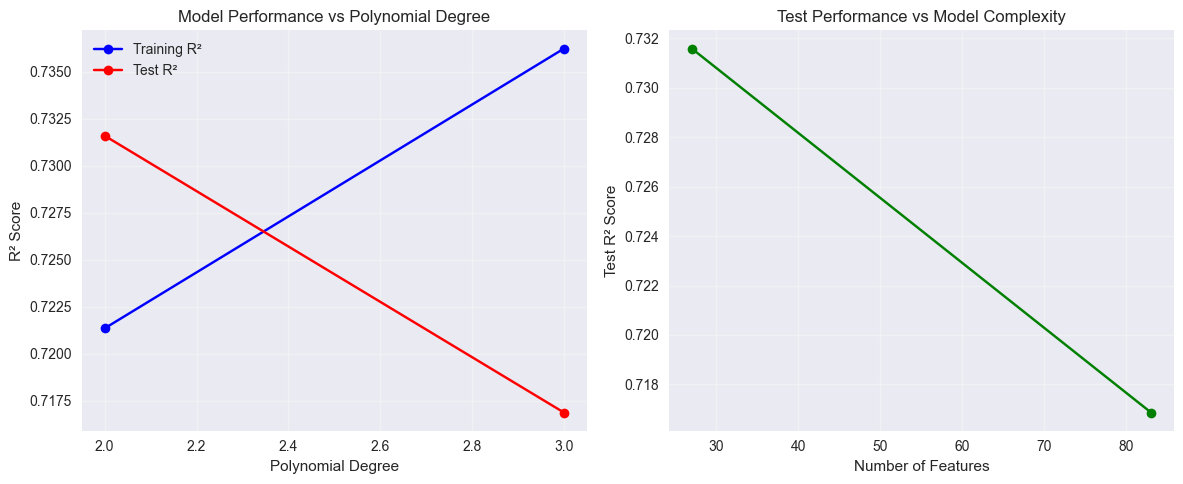

In [15]:
def train_polynomial_regression(X_train: np.ndarray, X_test: np.ndarray, 
                              y_train: np.ndarray, y_test: np.ndarray,
                              degrees: List[int] = [2, 3]) -> dict:
    """Train polynomial regression models.
    
    Args:
        X_train, X_test: Training and test features
        y_train, y_test: Training and test targets
        degrees: List of polynomial degrees to try
        
    Returns:
        Dictionary with polynomial models and results
    """
    poly_results = []
    poly_models = {}
    
    for degree in degrees:
        print(f"\nTraining Polynomial Regression (degree {degree})...")
        
        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly_features.fit_transform(X_train)
        X_test_poly = poly_features.transform(X_test)
        
        print(f"Original features: {X_train.shape[1]}")
        print(f"Polynomial features: {X_train_poly.shape[1]}")
        
        # Train model with regularization to prevent overfitting
        model = Ridge(alpha=1.0)  # Use Ridge to handle high-dimensional polynomial features
        model.fit(X_train_poly, y_train)
        
        # Evaluate
        train_pred = model.predict(X_train_poly)
        test_pred = model.predict(X_test_poly)
        
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        poly_results.append({
            'Degree': degree,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train RMSE': np.sqrt(mean_squared_error(y_train, train_pred)),
            'Test RMSE': np.sqrt(mean_squared_error(y_test, test_pred)),
            'Features': X_train_poly.shape[1]
        })
        
        poly_models[f'Poly_{degree}'] = {
            'model': model,
            'poly_features': poly_features
        }
    
    # Display results
    poly_df = pd.DataFrame(poly_results)
    print("\nPolynomial Regression Results:")
    print(poly_df.round(4))
    
    # Plot complexity vs performance
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(poly_df['Degree'], poly_df['Train R²'], 'o-', label='Training R²', color='blue')
    plt.plot(poly_df['Degree'], poly_df['Test R²'], 'o-', label='Test R²', color='red')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('R² Score')
    plt.title('Model Performance vs Polynomial Degree')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(poly_df['Features'], poly_df['Test R²'], 'o-', color='green')
    plt.xlabel('Number of Features')
    plt.ylabel('Test R² Score')
    plt.title('Test Performance vs Model Complexity')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return poly_models, poly_df

# Train polynomial regression models
poly_models, poly_results_df = train_polynomial_regression(X_train, X_test, y_train, y_test)

## 10. Model Comparison and Selection

Compare all models and select the best one based on multiple criteria.

=== MODEL COMPARISON SUMMARY ===

1. Linear Models:
               Model  Test R²   Test RMSE  CV R² Mean
0  Linear Regression   0.7259  40268.4857      0.7006
1   Ridge Regression   0.7259  40270.8978      0.7006
2   Lasso Regression   0.7259  40268.5797      0.7006

2. Polynomial Models:
   Degree  Test R²   Test RMSE  Features
0       2   0.7316  39849.8451        27
1       3   0.7169  40928.3669        83

=== MODEL SELECTION CRITERIA ===

Best Linear Model: Linear Regression
  - Test R²: 0.7259
  - Test RMSE: 40268.49
  - CV R² Mean: 0.7006

Best Polynomial Model: Degree 2.0
  - Test R²: 0.7316
  - Test RMSE: 39849.85
  - Features: 27.0

=== RECOMMENDATION ===
Recommended Model: Linear Regression
Reason: Simpler model with comparable performance (Occam's Razor)


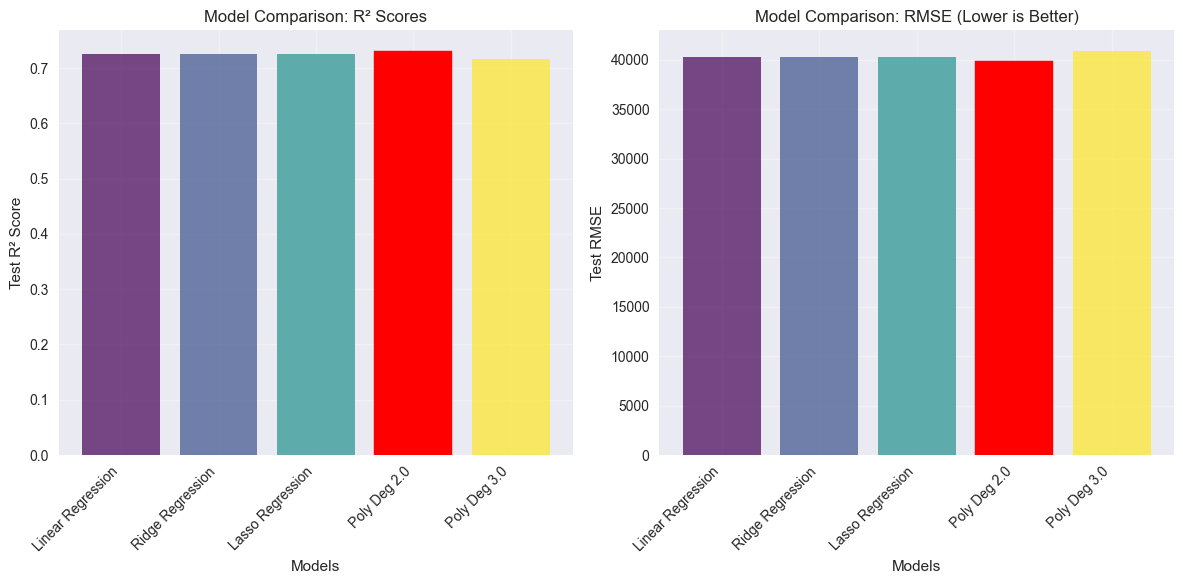

In [16]:
def compare_all_models() -> None:
    """Compare all trained models and provide recommendations."""
    print("=== MODEL COMPARISON SUMMARY ===")
    
    # Combine linear and polynomial results
    print("\n1. Linear Models:")
    print(evaluation_results[['Model', 'Test R²', 'Test RMSE', 'CV R² Mean']].round(4))
    
    print("\n2. Polynomial Models:")
    print(poly_results_df[['Degree', 'Test R²', 'Test RMSE', 'Features']].round(4))
    
    # Model selection criteria
    print("\n=== MODEL SELECTION CRITERIA ===")
    
    # Best linear model
    best_linear_idx = evaluation_results['Test R²'].idxmax()
    best_linear = evaluation_results.iloc[best_linear_idx]
    print(f"\nBest Linear Model: {best_linear['Model']}")
    print(f"  - Test R²: {best_linear['Test R²']:.4f}")
    print(f"  - Test RMSE: {best_linear['Test RMSE']:.2f}")
    print(f"  - CV R² Mean: {best_linear['CV R² Mean']:.4f}")
    
    # Best polynomial model
    best_poly_idx = poly_results_df['Test R²'].idxmax()
    best_poly = poly_results_df.iloc[best_poly_idx]
    print(f"\nBest Polynomial Model: Degree {best_poly['Degree']}")
    print(f"  - Test R²: {best_poly['Test R²']:.4f}")
    print(f"  - Test RMSE: {best_poly['Test RMSE']:.2f}")
    print(f"  - Features: {best_poly['Features']}")
    
    # Overall recommendation
    print("\n=== RECOMMENDATION ===")
    if best_linear['Test R²'] > best_poly['Test R²'] - 0.01:  # Small tolerance
        print(f"Recommended Model: {best_linear['Model']}")
        print("Reason: Simpler model with comparable performance (Occam's Razor)")
    else:
        print(f"Recommended Model: Polynomial Degree {best_poly['Degree']}")
        print("Reason: Significantly better performance justifies complexity")
    
    # Visualization of all models
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    all_models = []
    all_r2 = []
    all_rmse = []
    
    # Add linear models
    for _, row in evaluation_results.iterrows():
        all_models.append(row['Model'])
        all_r2.append(row['Test R²'])
        all_rmse.append(row['Test RMSE'])
    
    # Add polynomial models
    for _, row in poly_results_df.iterrows():
        all_models.append(f"Poly Deg {row['Degree']}")
        all_r2.append(row['Test R²'])
        all_rmse.append(row['Test RMSE'])
    
    # Plot R² scores
    plt.subplot(1, 2, 1)
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_models)))
    bars = plt.bar(range(len(all_models)), all_r2, color=colors, alpha=0.7)
    plt.xlabel('Models')
    plt.ylabel('Test R² Score')
    plt.title('Model Comparison: R² Scores')
    plt.xticks(range(len(all_models)), all_models, rotation=45, ha='right')
    
    # Highlight best model
    best_idx = np.argmax(all_r2)
    bars[best_idx].set_color('red')
    bars[best_idx].set_alpha(1.0)
    
    # Plot RMSE
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(len(all_models)), all_rmse, color=colors, alpha=0.7)
    plt.xlabel('Models')
    plt.ylabel('Test RMSE')
    plt.title('Model Comparison: RMSE (Lower is Better)')
    plt.xticks(range(len(all_models)), all_models, rotation=45, ha='right')
    
    # Highlight best model (lowest RMSE)
    best_rmse_idx = np.argmin(all_rmse)
    bars[best_rmse_idx].set_color('red')
    bars[best_rmse_idx].set_alpha(1.0)
    
    plt.tight_layout()
    plt.show()

# Compare all models
compare_all_models()

## 11. Real-World Application: California Housing Dataset

Apply our best model to a real dataset to validate its effectiveness.

=== REAL-WORLD VALIDATION ===
California Housing Dataset:
  - Samples: 20640
  - Features: 8
  - Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
  - Target: Median house value ($)

Real Data Results:
  - R² Score: 0.5758
  - RMSE: $74,558.14
  - MAE: $53,320.01

Feature Importance (Real Data):
      Feature   Coefficient  Abs_Coefficient
6    Latitude -89692.887664     89692.887664
7   Longitude -86984.177524     86984.177524
0      MedInc  85438.303093     85438.303093
3   AveBedrms  33925.949059     33925.949059
2    AveRooms -29441.013447     29441.013447
1    HouseAge  12254.623808     12254.623808
5    AveOccup  -4082.910309      4082.910309
4  Population   -230.772315       230.772315


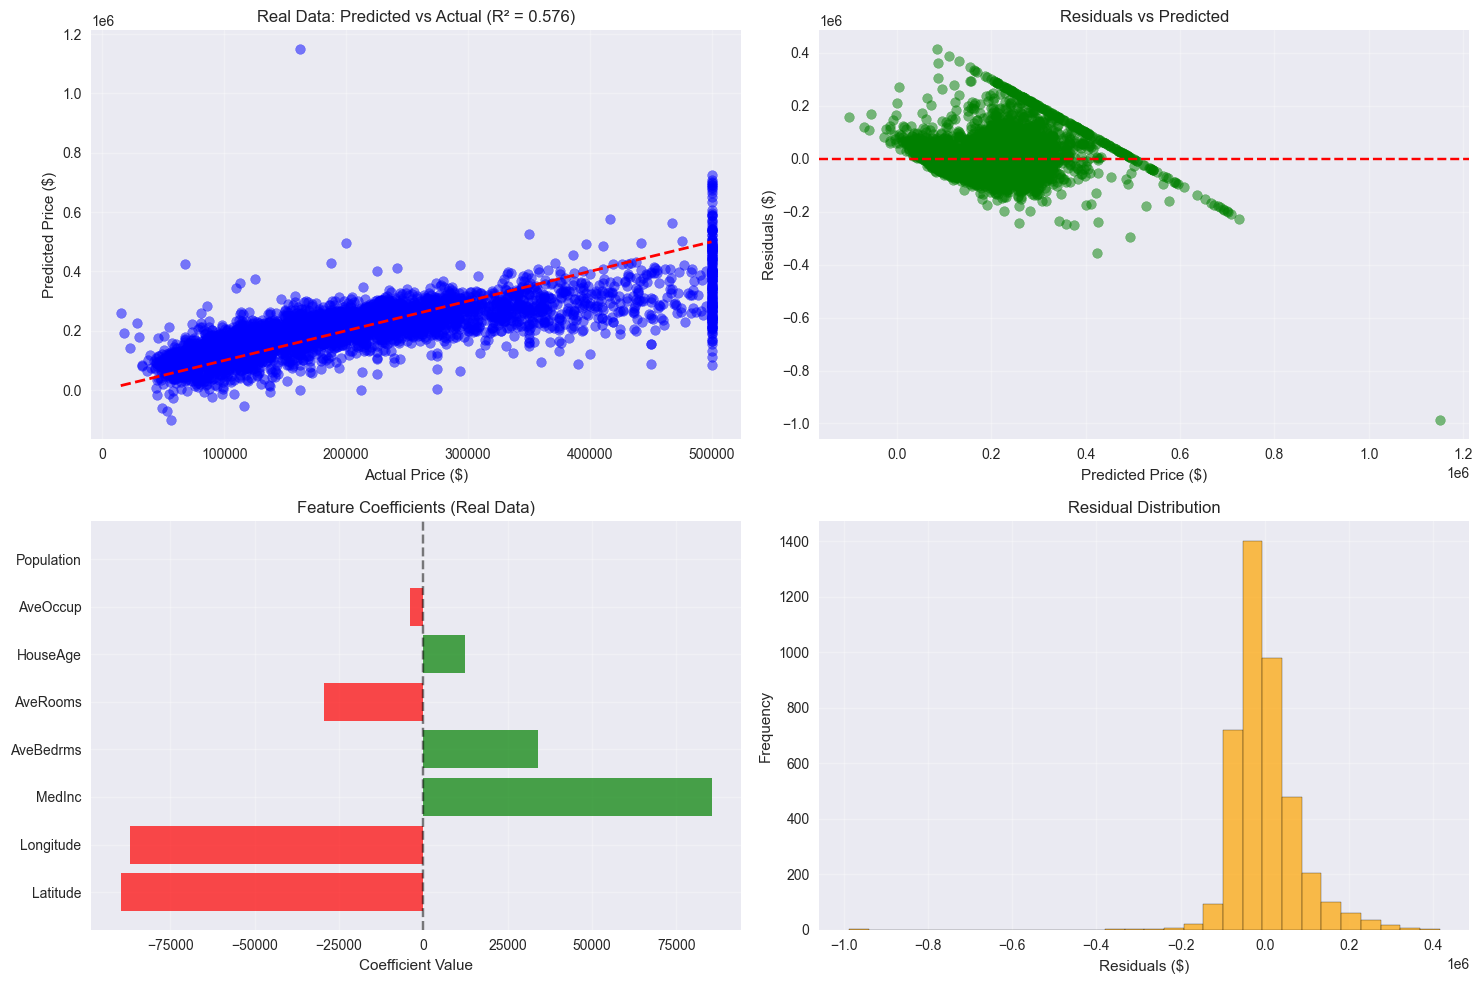

In [17]:
def apply_to_real_data() -> None:
    """Apply the best model to real California housing data."""
    print("=== REAL-WORLD VALIDATION ===")
    
    # Load California housing dataset
    california_data = fetch_california_housing()
    X_real = california_data.data
    y_real = california_data.target * 100000  # Convert to actual dollar values
    feature_names_real = california_data.feature_names
    
    print(f"California Housing Dataset:")
    print(f"  - Samples: {X_real.shape[0]}")
    print(f"  - Features: {X_real.shape[1]}")
    print(f"  - Features: {feature_names_real}")
    print(f"  - Target: Median house value ($)")
    
    # Split and scale data
    X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
        X_real, y_real, test_size=0.2, random_state=42
    )
    
    scaler_real = StandardScaler()
    X_train_real_scaled = scaler_real.fit_transform(X_train_real)
    X_test_real_scaled = scaler_real.transform(X_test_real)
    
    # Train our best model on real data
    best_model_real = LinearRegression()  # Use the model type that performed best
    best_model_real.fit(X_train_real_scaled, y_train_real)
    
    # Evaluate on real data
    y_pred_real = best_model_real.predict(X_test_real_scaled)
    
    r2_real = r2_score(y_test_real, y_pred_real)
    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mae_real = mean_absolute_error(y_test_real, y_pred_real)
    
    print(f"\nReal Data Results:")
    print(f"  - R² Score: {r2_real:.4f}")
    print(f"  - RMSE: ${rmse_real:,.2f}")
    print(f"  - MAE: ${mae_real:,.2f}")
    
    # Feature importance on real data
    importance_real = pd.DataFrame({
        'Feature': feature_names_real,
        'Coefficient': best_model_real.coef_,
        'Abs_Coefficient': np.abs(best_model_real.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nFeature Importance (Real Data):")
    print(importance_real)
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Predicted vs Actual
    plt.subplot(2, 2, 1)
    plt.scatter(y_test_real, y_pred_real, alpha=0.5, color='blue')
    plt.plot([y_test_real.min(), y_test_real.max()], 
             [y_test_real.min(), y_test_real.max()], 'r--', lw=2)
    plt.xlabel('Actual Price ($)')
    plt.ylabel('Predicted Price ($)')
    plt.title(f'Real Data: Predicted vs Actual (R² = {r2_real:.3f})')
    
    # Residuals
    residuals_real = y_test_real - y_pred_real
    plt.subplot(2, 2, 2)
    plt.scatter(y_pred_real, residuals_real, alpha=0.5, color='green')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Price ($)')
    plt.ylabel('Residuals ($)')
    plt.title('Residuals vs Predicted')
    
    # Feature importance
    plt.subplot(2, 2, 3)
    colors = ['red' if coef < 0 else 'green' for coef in importance_real['Coefficient']]
    plt.barh(importance_real['Feature'], importance_real['Coefficient'], 
             color=colors, alpha=0.7)
    plt.title('Feature Coefficients (Real Data)')
    plt.xlabel('Coefficient Value')
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    
    # Error distribution
    plt.subplot(2, 2, 4)
    plt.hist(residuals_real, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Residuals ($)')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution')
    
    plt.tight_layout()
    plt.show()

# Apply to real data
apply_to_real_data()

## 12. Summary and Key Takeaways

### What We Learned

1. **Linear Regression Fundamentals**: We implemented linear regression from scratch and using scikit-learn, understanding the mathematical foundation and assumptions.

2. **Data Preprocessing**: Proper data preprocessing including scaling, splitting, and handling different data types is crucial for model performance.

3. **Model Variants**: We explored different variants:
   - **Linear Regression**: Basic least squares solution
   - **Ridge Regression**: L2 regularization to prevent overfitting
   - **Lasso Regression**: L1 regularization for feature selection
   - **Polynomial Regression**: Capturing non-linear relationships

4. **Evaluation Metrics**: Multiple metrics provide different insights:
   - **R²**: Proportion of variance explained
   - **RMSE**: Root mean squared error in original units
   - **MAE**: Mean absolute error, robust to outliers

5. **Model Interpretation**: Linear models are highly interpretable through coefficient analysis.

6. **Residual Analysis**: Checking model assumptions through residual patterns.

### Best Practices

1. **Always scale features** when using regularized models
2. **Use cross-validation** for robust performance estimation
3. **Analyze residuals** to validate model assumptions
4. **Consider regularization** to prevent overfitting
5. **Test on real data** to validate model generalization

### When to Use Linear Regression

**Good for:**
- Linear relationships between features and target
- Interpretability is important
- Baseline model for comparison
- Small to medium datasets
- When you need to understand feature importance

**Not ideal for:**
- Highly non-linear relationships
- Very high-dimensional data without regularization
- When interpretability is not needed and accuracy is paramount

### Next Steps

1. Explore **ensemble methods** like Random Forest
2. Try **non-linear models** like SVM or Neural Networks
3. Implement **feature engineering** techniques
4. Learn about **advanced regularization** methods
5. Study **time series** regression for temporal data

## 13. Practice Exercises

### Exercise 1: Feature Engineering
Create new features from existing ones (e.g., price per square foot, age categories) and see how they affect model performance.

### Exercise 2: Outlier Detection
Implement outlier detection and removal techniques and analyze their impact on model performance.

### Exercise 3: Different Datasets
Apply the same pipeline to other regression datasets (e.g., Boston housing, automobile prices).

### Exercise 4: Hyperparameter Tuning
Use GridSearchCV to find optimal regularization parameters for Ridge and Lasso regression.

### Exercise 5: Advanced Metrics
Implement additional evaluation metrics like MAPE (Mean Absolute Percentage Error) and analyze when each metric is most appropriate.